Using device: cpu


C:\Users\jbkee\AppData\Local\Temp\ipykernel_28844\3491696445.py:72: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\jbkee\AppData\Local\Temp\ipykernel_28844\3491696445.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is 

Epoch 1: Loss = 39.5903
Epoch 2: Loss = 28.9740
Epoch 3: Loss = 21.5153
Epoch 4: Loss = 17.2316
Epoch 5: Loss = 12.9855
Epoch 6: Loss = 10.1614
Epoch 7: Loss = 7.8252
Epoch 8: Loss = 5.5015
Epoch 9: Loss = 4.7573
Epoch 10: Loss = 3.1030
Epoch 11: Loss = 1.9882
Epoch 12: Loss = 1.5990
Epoch 13: Loss = 1.1740
Epoch 14: Loss = 0.9913
Epoch 15: Loss = 0.8035
Epoch 16: Loss = 0.5072
Epoch 17: Loss = 0.3858
Epoch 18: Loss = 0.3135
Epoch 19: Loss = 0.2698
Epoch 20: Loss = 0.2250
Epoch 21: Loss = 0.1997
Epoch 22: Loss = 0.1786
Epoch 23: Loss = 0.1575
Epoch 24: Loss = 0.1360
Epoch 25: Loss = 0.1217
Epoch 26: Loss = 0.1086
Epoch 27: Loss = 0.0967
Epoch 28: Loss = 0.0891
Epoch 29: Loss = 0.0834
Epoch 30: Loss = 0.0751
Epoch 31: Loss = 0.0687
Epoch 32: Loss = 0.0634
Epoch 33: Loss = 0.0600
Epoch 34: Loss = 0.0575
Epoch 35: Loss = 0.0543
Epoch 36: Loss = 0.0504
Epoch 37: Loss = 0.0472
Epoch 38: Loss = 0.0476
Epoch 39: Loss = 0.0455
Epoch 40: Loss = 0.0394
Epoch 41: Loss = 0.0366
Epoch 42: Loss = 0.

C:\Users\jbkee\AppData\Local\Temp\ipykernel_28844\3491696445.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


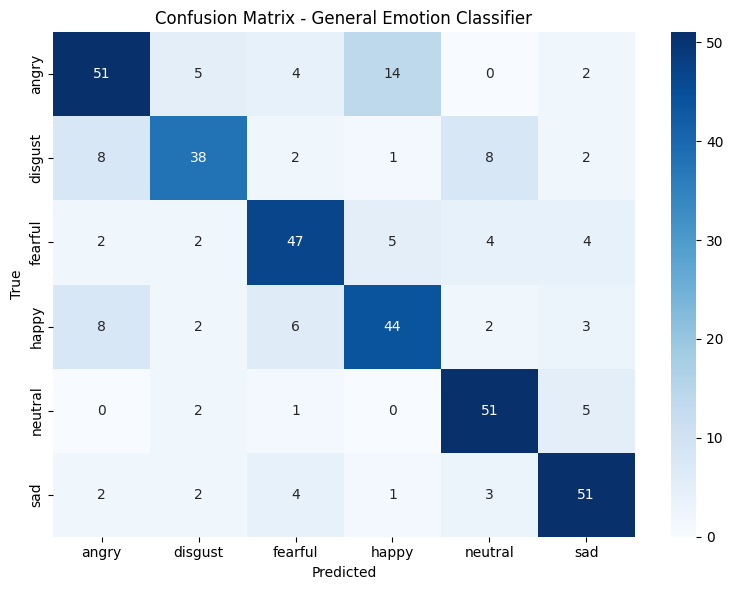

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif

In [ ]:

# Load a fresh copy
df = pd.read_csv("combined_features.csv")

# Encode emotion labels
le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion"])

# Select features + label
X = df.drop(columns=["emotion", "emotion_encoded", "filename"], errors="ignore")
y = df["emotion_encoded"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Device selection ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# MLP model
class MultiClassMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

general_model = MultiClassMLP(X_train.shape[1], len(le.classes_)).to(device)

# Loss, Optimizer, AMP scaler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(general_model.parameters(), lr=1e-3)
scaler = GradScaler()

# === Compute ANOVA F-scores ===
f_scores, _ = f_classif(X_train_scaled, y_train)

# === Select top features by threshold ===
threshold = 10  # Adjust as needed
general_features = np.where(f_scores >= threshold)[0]
X_train_selected = X_train_scaled[:, general_features]
X_test_selected = X_test_scaled[:, general_features]

# Replace tensors
X_train_t = torch.tensor(X_train_selected, dtype=torch.float32)
X_test_t = torch.tensor(X_test_selected, dtype=torch.float32)

# Training loop with AMP
for epoch in range(50):
    general_model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast():
            logits = general_model(xb)
            loss = loss_fn(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# Evaluation
general_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        with autocast():
            logits = general_model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Classification report
labels = np.arange(len(le.classes_))
print(classification_report(y_test, all_preds, labels=labels, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - General Emotion Classifier")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[angry] Selected 574 features
Epoch 1: Loss = 10.8961
Epoch 2: Loss = 7.7423
Epoch 3: Loss = 6.0962
Epoch 4: Loss = 4.8229
Epoch 5: Loss = 3.9166
Epoch 6: Loss = 3.0361
Epoch 7: Loss = 2.2815
Epoch 8: Loss = 1.5207
Epoch 9: Loss = 1.5583
Epoch 10: Loss = 0.7351
Epoch 11: Loss = 0.5862
Epoch 12: Loss = 0.3015
Epoch 13: Loss = 0.1867
Epoch 14: Loss = 0.1003
Epoch 15: Loss = 0.0681
Epoch 16: Loss = 0.0567
Epoch 17: Loss = 0.0435
Epoch 18: Loss = 0.0348
Epoch 19: Loss = 0.0297
Epoch 20: Loss = 0.0256
Epoch 21: Loss = 0.0218
Epoch 22: Loss = 0.0195
Epoch 23: Loss = 0.0177
Epoch 24: Loss = 0.0157
Epoch 25: Loss = 0.0138
Epoch 26: Loss = 0.0126
Epoch 27: Loss = 0.0115
Epoch 28: Loss = 0.0106
Epoch 29: Loss = 0.0096
Epoch 30: Loss = 0.0091
Epoch 31: Loss = 0.0085
Epoch 32: Loss = 0.0085
Epoch 33: Loss = 0.0071
Epoch 34: Loss = 0.0068
Epoch 35: Loss = 0.0061
Epoch 36: Loss = 0.0059
Epoch 37: Loss = 0.0053
Epoch 38: Loss = 0.0051
Epoch 39: Loss = 0.0047
Epoch 40: Loss = 0.0048
Epoch 41: Loss = 0

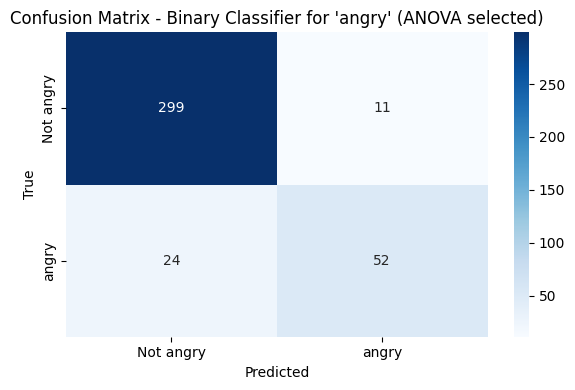

In [2]:
# === Set target emotion ===
target_emotion = "angry"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
angry_features = feature_scores[feature_scores.f_score > 10]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(angry_features)} features")

# === Prepare Train/Test ===
X_selected = df[angry_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

angry_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(angry_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    angry_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = angry_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
angry_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = angry_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[disgust] Selected 459 features
Epoch 1: Loss = 10.7309
Epoch 2: Loss = 7.8768
Epoch 3: Loss = 6.6553
Epoch 4: Loss = 5.5183
Epoch 5: Loss = 4.5758
Epoch 6: Loss = 3.7701
Epoch 7: Loss = 2.8931
Epoch 8: Loss = 2.6758
Epoch 9: Loss = 1.9204
Epoch 10: Loss = 2.2242
Epoch 11: Loss = 1.4994
Epoch 12: Loss = 1.1227
Epoch 13: Loss = 0.8646
Epoch 14: Loss = 0.9085
Epoch 15: Loss = 0.5873
Epoch 16: Loss = 0.4448
Epoch 17: Loss = 0.4651
Epoch 18: Loss = 0.3513
Epoch 19: Loss = 0.3365
Epoch 20: Loss = 0.1945
Epoch 21: Loss = 0.2552
Epoch 22: Loss = 0.1124
Epoch 23: Loss = 0.1303
Epoch 24: Loss = 0.0591
Epoch 25: Loss = 0.0526
Epoch 26: Loss = 0.0464
Epoch 27: Loss = 0.0265
Epoch 28: Loss = 0.0195
Epoch 29: Loss = 0.0178
Epoch 30: Loss = 0.0152
Epoch 31: Loss = 0.0122
Epoch 32: Loss = 0.0108
Epoch 33: Loss = 0.0096
Epoch 34: Loss = 0.0083
Epoch 35: Loss = 0.0074
Epoch 36: Loss = 0.0065
Epoch 37: Loss = 0.0060
Epoch 38: Loss = 0.0052
Epoch 39: Loss = 0.0048
Epoch 40: Loss = 0.0042
Epoch 41: Loss =

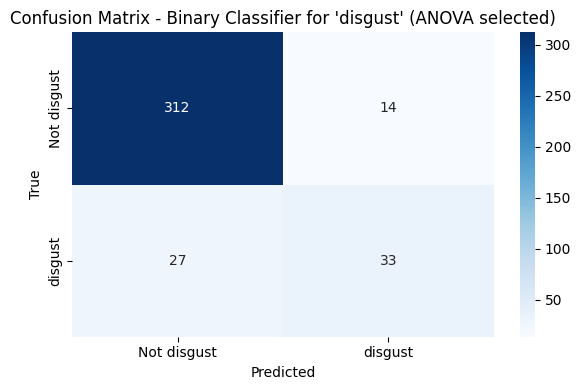

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "disgust"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
disgust_features = feature_scores[feature_scores.f_score > 10]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(disgust_features)} features")

# === Prepare Train/Test ===
X_selected = df[disgust_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

disgust_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(disgust_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    disgust_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = disgust_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
disgust_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = disgust_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[fearful] Selected 589 features
Epoch 1: Loss = 12.0785
Epoch 2: Loss = 8.3278
Epoch 3: Loss = 6.5741
Epoch 4: Loss = 5.1885
Epoch 5: Loss = 3.9392
Epoch 6: Loss = 2.9949
Epoch 7: Loss = 2.0989
Epoch 8: Loss = 1.3275
Epoch 9: Loss = 1.2472
Epoch 10: Loss = 0.6397
Epoch 11: Loss = 0.3373
Epoch 12: Loss = 0.1806
Epoch 13: Loss = 0.1188
Epoch 14: Loss = 0.0679
Epoch 15: Loss = 0.0465
Epoch 16: Loss = 0.0371
Epoch 17: Loss = 0.0296
Epoch 18: Loss = 0.0262
Epoch 19: Loss = 0.0222
Epoch 20: Loss = 0.0193
Epoch 21: Loss = 0.0174
Epoch 22: Loss = 0.0152
Epoch 23: Loss = 0.0128
Epoch 24: Loss = 0.0116
Epoch 25: Loss = 0.0105
Epoch 26: Loss = 0.0099
Epoch 27: Loss = 0.0088
Epoch 28: Loss = 0.0081
Epoch 29: Loss = 0.0075
Epoch 30: Loss = 0.0071
Epoch 31: Loss = 0.0061
Epoch 32: Loss = 0.0058
Epoch 33: Loss = 0.0053
Epoch 34: Loss = 0.0049
Epoch 35: Loss = 0.0047
Epoch 36: Loss = 0.0043
Epoch 37: Loss = 0.0042
Epoch 38: Loss = 0.0037
Epoch 39: Loss = 0.0036
Epoch 40: Loss = 0.0033
Epoch 41: Loss =

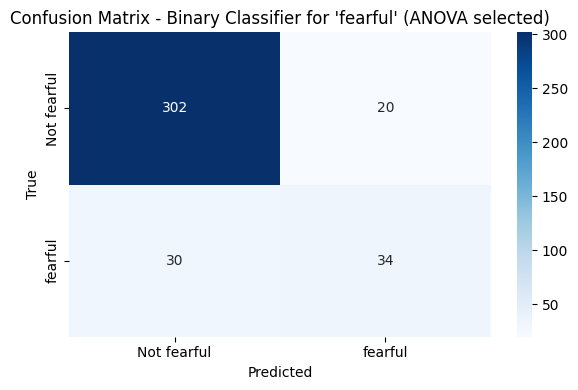

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "fearful"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
fearful_features = feature_scores[feature_scores.f_score > 1]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(fearful_features)} features")

# === Prepare Train/Test ===
X_selected = df[fearful_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

fearful_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(fearful_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    fearful_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = fearful_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
fearful_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = fearful_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[happy] Selected 325 features
Epoch 1: Loss = 11.2240
Epoch 2: Loss = 8.7043
Epoch 3: Loss = 7.6092
Epoch 4: Loss = 6.3091
Epoch 5: Loss = 5.1416
Epoch 6: Loss = 3.9935
Epoch 7: Loss = 3.3181
Epoch 8: Loss = 2.6876
Epoch 9: Loss = 2.1055
Epoch 10: Loss = 1.3044
Epoch 11: Loss = 0.6856
Epoch 12: Loss = 0.4819
Epoch 13: Loss = 0.2621
Epoch 14: Loss = 0.1752
Epoch 15: Loss = 0.1114
Epoch 16: Loss = 0.0902
Epoch 17: Loss = 0.0736
Epoch 18: Loss = 0.0552
Epoch 19: Loss = 0.0462
Epoch 20: Loss = 0.0383
Epoch 21: Loss = 0.0310
Epoch 22: Loss = 0.0305
Epoch 23: Loss = 0.0237
Epoch 24: Loss = 0.0211
Epoch 25: Loss = 0.0184
Epoch 26: Loss = 0.0167
Epoch 27: Loss = 0.0152
Epoch 28: Loss = 0.0138
Epoch 29: Loss = 0.0123
Epoch 30: Loss = 0.0113
Epoch 31: Loss = 0.0101
Epoch 32: Loss = 0.0092
Epoch 33: Loss = 0.0084
Epoch 34: Loss = 0.0077
Epoch 35: Loss = 0.0074
Epoch 36: Loss = 0.0066
Epoch 37: Loss = 0.0065
Epoch 38: Loss = 0.0060
Epoch 39: Loss = 0.0053
Epoch 40: Loss = 0.0050
Epoch 41: Loss = 0

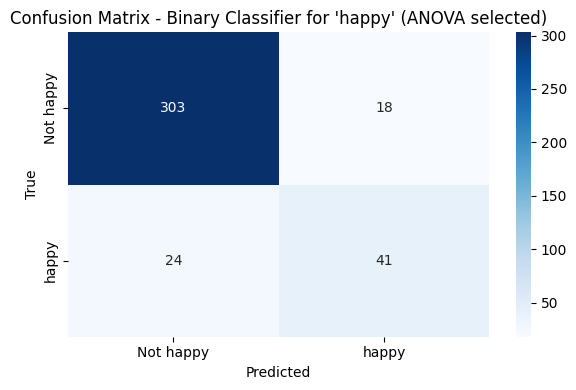

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "happy"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
happy_features = feature_scores[feature_scores.f_score > 9.5]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(happy_features)} features")

# === Prepare Train/Test ===
X_selected = df[happy_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

happy_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(happy_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    happy_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = happy_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
happy_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = happy_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[neutral] Selected 344 features
Epoch 1: Loss = 11.4264
Epoch 2: Loss = 6.6588
Epoch 3: Loss = 5.1874
Epoch 4: Loss = 3.6193
Epoch 5: Loss = 2.6424
Epoch 6: Loss = 2.0718
Epoch 7: Loss = 1.4730
Epoch 8: Loss = 1.3538
Epoch 9: Loss = 0.8033
Epoch 10: Loss = 0.6256
Epoch 11: Loss = 0.3565
Epoch 12: Loss = 0.4718
Epoch 13: Loss = 0.2128
Epoch 14: Loss = 0.1095
Epoch 15: Loss = 0.0742
Epoch 16: Loss = 0.0504
Epoch 17: Loss = 0.0381
Epoch 18: Loss = 0.0309
Epoch 19: Loss = 0.0258
Epoch 20: Loss = 0.0228
Epoch 21: Loss = 0.0189
Epoch 22: Loss = 0.0173
Epoch 23: Loss = 0.0154
Epoch 24: Loss = 0.0132
Epoch 25: Loss = 0.0113
Epoch 26: Loss = 0.0102
Epoch 27: Loss = 0.0094
Epoch 28: Loss = 0.0085
Epoch 29: Loss = 0.0074
Epoch 30: Loss = 0.0069
Epoch 31: Loss = 0.0070
Epoch 32: Loss = 0.0057
Epoch 33: Loss = 0.0052
Epoch 34: Loss = 0.0051
Epoch 35: Loss = 0.0050
Epoch 36: Loss = 0.0044
Epoch 37: Loss = 0.0040
Epoch 38: Loss = 0.0036
Epoch 39: Loss = 0.0039
Epoch 40: Loss = 0.0033
Epoch 41: Loss =

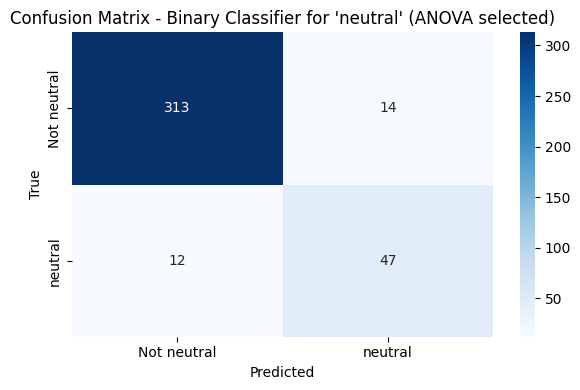

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "neutral"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
neutral_features = feature_scores[feature_scores.f_score > 10]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(neutral_features)} features")

# === Prepare Train/Test ===
X_selected = df[neutral_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

neutral_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(neutral_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    neutral_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = neutral_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
neutral_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = neutral_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[sad] Selected 578 features
Epoch 1: Loss = 11.6620
Epoch 2: Loss = 8.1188
Epoch 3: Loss = 6.7035
Epoch 4: Loss = 5.9127
Epoch 5: Loss = 4.7165
Epoch 6: Loss = 3.7361
Epoch 7: Loss = 3.5877
Epoch 8: Loss = 2.4370
Epoch 9: Loss = 2.2131
Epoch 10: Loss = 1.4211
Epoch 11: Loss = 0.8889
Epoch 12: Loss = 0.8402
Epoch 13: Loss = 1.0749
Epoch 14: Loss = 0.8818
Epoch 15: Loss = 0.3504
Epoch 16: Loss = 0.1886
Epoch 17: Loss = 0.1288
Epoch 18: Loss = 0.0692
Epoch 19: Loss = 0.0510
Epoch 20: Loss = 0.0396
Epoch 21: Loss = 0.0335
Epoch 22: Loss = 0.0289
Epoch 23: Loss = 0.0236
Epoch 24: Loss = 0.0206
Epoch 25: Loss = 0.0182
Epoch 26: Loss = 0.0166
Epoch 27: Loss = 0.0146
Epoch 28: Loss = 0.0131
Epoch 29: Loss = 0.0118
Epoch 30: Loss = 0.0109
Epoch 31: Loss = 0.0097
Epoch 32: Loss = 0.0092
Epoch 33: Loss = 0.0081
Epoch 34: Loss = 0.0080
Epoch 35: Loss = 0.0074
Epoch 36: Loss = 0.0067
Epoch 37: Loss = 0.0064
Epoch 38: Loss = 0.0057
Epoch 39: Loss = 0.0055
Epoch 40: Loss = 0.0050
Epoch 41: Loss = 0.0

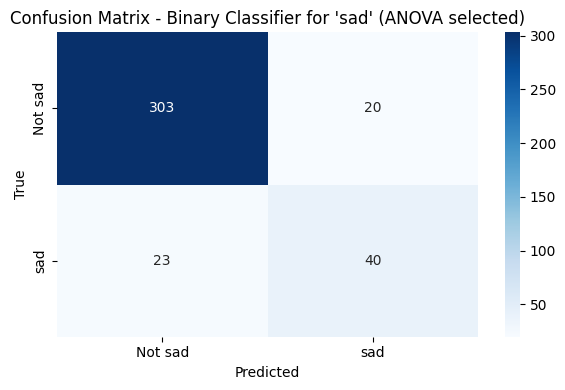

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "sad"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
sad_features = feature_scores[feature_scores.f_score > 5]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(sad_features)} features")

# === Prepare Train/Test ===
X_selected = df[sad_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

sad_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(sad_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    sad_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = sad_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
sad_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = sad_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


In [ ]:
models = {
    "happy": happy_model,
    "angry": angry_model,
    "disgust": disgust_model,
    "fearful": fearful_model,
    "neutral": neutral_model,
    "sad": sad_model,
    "general": general_model
}
emotion_features = {
    "happy": happy_features,
    "angry": angry_features,
    "disgust": disgust_features,
    "fearful": fearful_features,
    "neutral": neutral_features,
    "sad": sad_features,
    "general": general_features
}


In [9]:
for model in models.keys():
    print(f"Model for {model}:")
    print(models[model])
    print("\n")

for emotion in emotion_features.keys():
    print(f"Features for {emotion}:")
    print(emotion_features[emotion])
    print("\n")


Model for happy:
BinaryMLP(
  (model): Sequential(
    (0): Linear(in_features=325, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Model for angry:
BinaryMLP(
  (model): Sequential(
    (0): Linear(in_features=574, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Model for disgust:
BinaryMLP(
  (model): Sequential(
    (0): Linear(in_features=459, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Model for fearful:
BinaryMLP(
  (model): Sequential(
    (0): Linear(in_features=589, out_features=128, bias=True)
    (1)

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

# === Train the reranker model ===
# Prepare training data for the reranker
rerank_train_X = []
rerank_train_y = []

for xb, yb in train_loader:
    xb = xb.to(device)
    with torch.no_grad():
        xb_general = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        probs = torch.softmax(models["general"](xb_general), dim=1).cpu().numpy()
        top2 = np.argsort(probs, axis=1)[:, -2:][:, ::-1]

        for i in range(len(xb)):
            label1, label2 = le.classes_[top2[i][0]], le.classes_[top2[i][1]]

            row = X_train.iloc[len(rerank_train_y)]
            f1 = emotion_features[label1]
            f2 = emotion_features[label2]

            x1 = torch.tensor(row[f1].values, dtype=torch.float32).to(device).unsqueeze(0)
            x2 = torch.tensor(row[f2].values, dtype=torch.float32).to(device).unsqueeze(0)

            b1 = models[label1](x1).item()
            b2 = models[label2](x2).item()

            rerank_train_X.append([b1, b2])
            rerank_train_y.append(1 if yb[i].item() == top2[i][0] else 0)

# Train the logistic regression model
regressor_model = LogisticRegression()
regressor_model.fit(rerank_train_X, rerank_train_y)





RuntimeError: mat1 and mat2 shapes cannot be multiplied (1544x578 and 798x128)

              precision    recall  f1-score   support

       angry       0.85      0.24      0.37       323
     disgust       0.14      0.14      0.14        63
     fearful       0.00      0.00      0.00         0
       happy       0.00      0.00      0.00         0
     neutral       0.00      0.00      0.00         0
         sad       0.00      0.00      0.00         0

    accuracy                           0.22       386
   macro avg       0.16      0.06      0.09       386
weighted avg       0.73      0.22      0.33       386



C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

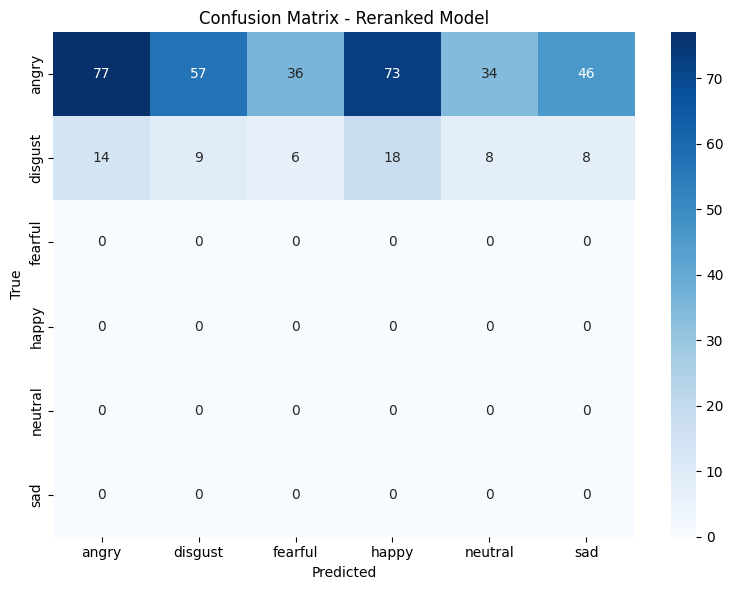

In [ ]:
# === Evaluate reranker and collect predictions ===
true_labels = []
pred_labels = []

# Reload and match original feature set
df = pd.read_csv("combined_features.csv")
X_full = df.drop(columns=["emotion", "emotion_encoded", "filename"], errors="ignore")
X_test_df = pd.DataFrame(X_test_scaled, columns=X_full.columns)

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        # Get top-2 predictions from the general model
        xb_general = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        probs = torch.softmax(models["general"](xb_general), dim=1).cpu().numpy()
        top2 = np.argsort(probs, axis=1)[:, -2:][:, ::-1]

        for i in range(len(xb)):
            label1, label2 = le.classes_[top2[i][0]], le.classes_[top2[i][1]]

            # Extract features for the top-2 emotions
            row = X_test_df.iloc[len(true_labels)]
            f1 = emotion_features[label1]
            f2 = emotion_features[label2]

            x1 = torch.tensor(row[f1].values, dtype=torch.float32).to(device).unsqueeze(0)
            x2 = torch.tensor(row[f2].values, dtype=torch.float32).to(device).unsqueeze(0)

            # Get binary classifier outputs
            b1 = models[label1](x1).item()
            b2 = models[label2](x2).item()

            # Use the reranker to decide between the two
            rerank_decision = regressor_model.predict([[b1, b2]])[0]
            final_prediction = top2[i][0] if rerank_decision == 1 else top2[i][1]

            pred_labels.append(final_prediction)
            true_labels.append(yb[i].item())

# === Classification Report ===
print(classification_report(true_labels, pred_labels, target_names=le.classes_))

# === Confusion Matrix ===
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Reranked Model")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 1: Build feature set for meta-classifier ===
emotion_labels = list(models.keys())
X_binary_meta = []
y_binary_meta = []

# Reload original full feature set to get column names
df = pd.read_csv("combined_features.csv")
X_full = df.drop(columns=["emotion", "emotion_encoded", "filename"], errors="ignore")
X_test_df = pd.DataFrame(X_test_scaled, columns=X_full.columns)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for idx in range(len(X_test_df)):
    sample_row = X_test_df.iloc[idx]
    probs = []

    for emotion in emotion_labels:
        features = emotion_features[emotion]
        x_emotion = torch.tensor(sample_row[features].values, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = models[emotion](x_emotion).squeeze()
            # Ensure logits is a scalar or 1D tensor before applying sigmoid
            if logits.dim() > 1:
                logits = logits.squeeze()
            logits = logits.squeeze()  # Ensure logits is a scalar or 1D tensor
            p = torch.sigmoid(logits).squeeze().item()
        probs.append(p)

    X_binary_meta.append(probs)
    y_binary_meta.append(le.transform([y_test.iloc[idx]])[0])  # convert label to numeric

# === Step 2: Train reranker ===
# Ensure the input dimension matches the number of features in X_binary_meta
input_dim = len(X_binary_meta[0])  # Number of features in the input tensor
for emotion in emotion_labels:
    if models[emotion].model[0].in_features != len(emotion_features[emotion]):
        models[emotion] = BinaryMLP(len(emotion_features[emotion])).to(device)

meta_clf = LogisticRegression(max_iter=500)
meta_clf.fit(X_binary_meta, y_binary_meta)

# === Step 3: Predict and Evaluate ===
y_pred = meta_clf.predict(X_binary_meta)

print("Classification Report - Meta Classifier on Binary Outputs:\n")
print(classification_report(y_binary_meta, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_binary_meta, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Meta Classifier from Binary Confidence Levels")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Temp\ipykernel_20848\950094341.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_emotion = torch.tensor(sample_row[features].values, dtype=torch.float32).unsqueeze(0).to(device)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x536 and 798x128)